# <b> Duffing oscillator model </b>
***

In [298]:
# Importing relevant stuff
import numpy as np, numpy
import time as tm
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-dark')

In [299]:
from tvb.simulator.models.base import Model
from tvb.basic.neotraits.api import NArray, List, Range, Final

from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.fmri_balloon as bold

from tvb.simulator.lab import *

In [300]:
import os
import scipy
import h5py

In [301]:
from scipy.io import loadmat
from scipy.signal import resample, square

### <b> Creating the model </b>
***

In [302]:
class DuffingOscillator(Model):
    alpha = NArray(
        label=":math:`\alpha`",
        default=np.array([-1]),
        domain=Range(lo=-15.0, hi=15.0, step=0.01),
        doc="""Controls the linear stiffness""",
    )
    
    beta = NArray(
        label=":math:`\delta`",
        default=np.array([1]),
        domain=Range(lo=0.001, hi=15.0, step=0.01),
        doc="""Controls the amount of non-linearity in the restoring force""",
    )
    
    delta = NArray(
        label=":math:`\delta`",
        default=np.array([0.2]),
        domain=Range(lo=0.001, hi=15.0, step=0.01),
        doc="""Controls the amount of damping""",
    )
    
    gamma = NArray(
        label=":math:`\gamma`",
        default=np.array([0.3]),
        domain=Range(lo=0.001, hi=15.0, step=0.01),
        doc="""Amplitude of the periodic driving force""",
    )
    
    omega = NArray(
        label=":math:`\omega`",
        default=np.array([0.01]),
        domain=Range(lo=0.001, hi=15.0, step=0.01),
        doc="""Angular frequency of the periodic driving force""",
    )
        
        #Informational attribute, used for phase-plane and initial()
    state_variable_range = Final(
        label="State Variable ranges [lo, hi]",
        default={"x": np.array([1., 1.]),
                 "y": np.array([0., 0.]),
                 "z": np.array([0., 0.])},
        doc="""Expected ranges of the state variables for initial condition generation and phase plane setup.""",
    )

    state_variable_boundaries = Final(
            label="State Variable boundaries [lo, hi]",
            default={"x": np.array([np.NINF, np.inf])},
    )
    
    variables_of_interest = List(
            of=str,
            label="Variables or quantities available to Monitors",
            choices=("x", "y", "z"),
            default=("x", "y", "z"),
            doc="The quantities of interest for monitoring for the Duffin oscillator.",
    )
    # State variables
    state_variables = ('x','y','z')
    _nvar = 3
    # Cvar is the coupling variable. 
    cvar = np.array([0], dtype=np.int32)
    
    def dfun(self, state_variables, coupling, local_coupling=0.0):
        x, y, z = state_variables
        
        #[State_variables, nodes]
        alpha = self.alpha
        beta  = self.beta
        delta = self.delta
        gamma = self.gamma
        omega = self.omega
        
        derivative = numpy.empty_like(state_variables)
        
        derivative[0] = y
        derivative[1] = (-delta*y) - (alpha*x) - (beta*(x**3)) + (gamma*np.cos(omega*z))
        derivative[2] = 1
        
        return derivative

### <b> Setting up the network </b>
***

In [303]:
# Setting up a 1 node network
conn1node = connectivity.Connectivity(weights=np.array([[0]]),
                                      tract_lengths=np.array([[0]]),
                                      region_labels=np.array(['Region']),
                                      centres=np.array([[0, 0, 0]]),
                                     )
conn1node.configure()

In [304]:
# Setting up integration time and simulation length
dt = 0.1
simlen = 1000 * 30

In [305]:
# Setting up the monitors
mon_tavg = monitors.TemporalAverage(period=5)
mon_bold = monitors.Bold(period=2000)
what_to_watch = (mon_tavg, mon_bold)

In [306]:
# Setting up the noise and the coupling
    # Noise
nsigma = .0002
nsigma_dom = [0, 0, 0]
hiss = noise.Additive(nsig=np.array(nsigma_dom))
heunint = integrators.HeunStochastic(dt = dt, noise = hiss)
    # Coupling
G = .1
con_coupling = coupling.Scaling(a = np.array(G))

In [307]:
# Setting up the model
dom = DuffingOscillator(omega = np.array([((2*np.pi)*10)/1000]),
                        alpha = np.array([-1.]),
                        delta = np.array([.3]),
                        gamma = np.array([.5]),
                       )
dom

,value
Type,DuffingOscillator
"alpha [min, median, max]","[-1, -1, -1]"
alpha dtype,float64
alpha shape,"(1,)"
"beta [min, median, max]","[1, 1, 1]"
beta dtype,int64
beta shape,"(1,)"
"delta [min, median, max]","[0.3, 0.3, 0.3]"
delta dtype,float64
delta shape,"(1,)"


/home/marindauguet/anaconda3/envs/py3/lib/python3.9/site-packages/matplotlib/streamplot.py:278: RuntimeWarning: divide by zero encountered in double_scalars
  self.x_data2grid = 1. / grid.dx
/home/marindauguet/anaconda3/envs/py3/lib/python3.9/site-packages/matplotlib/streamplot.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  self.y_data2grid = 1. / grid.dy
<ipython-input-282-bc984d239bb0>:65: UserWarning: No contour levels were found within the data range.
  ax.contour(xx,yy,dx, [0], colors="r", alpha=alpha)
<ipython-input-282-bc984d239bb0>:66: UserWarning: No contour levels were found within the data range.
  ax.contour(xx,yy,dy, [0], colors="g", alpha=alpha)
<ipython-input-282-bc984d239bb0>:67: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)
<ipython-input-282-bc984d239bb0>:68: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transfor

<AxesSubplot:title={'center':'DuffingOscillator'}, xlabel='x', ylabel='y'>

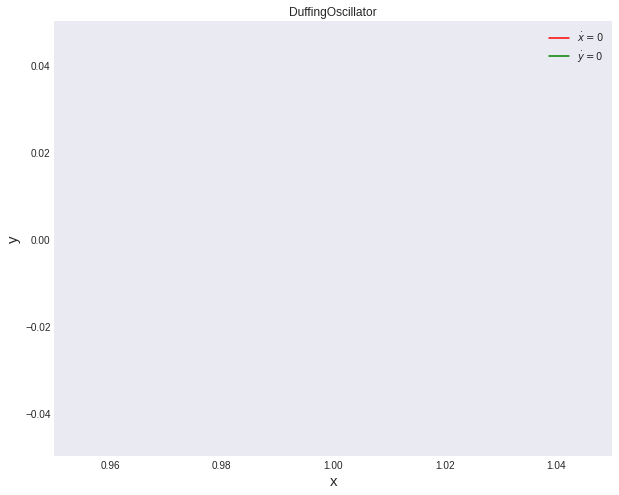

In [308]:
phase_plane(dom)

### <b> Launching the simulation </b>
***

In [309]:
# Setting up the simulation
sim = simulator.Simulator(model = dom,
                          connectivity = conn1node,
                          conduction_speed = np.inf,
                          coupling = con_coupling,
                          integrator = heunint,
                          monitors = what_to_watch,
                          simulation_length = simlen,
                         )
sim.configure()

   INFO  White noise configured with dt=0.1


,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 9e137855-0ea1-476d-b0b6-1d5aaa575180
coupling,Scaling gid: fb536ee5-f9f2-4f53-900f-fa8d0dee1687
gid,UUID('c4428202-fdc6-42c0-80d1-f199bacd82c2')
initial_conditions,None
integrator,HeunStochastic gid: 1fe256f8-a034-46a6-8797-e492f56eb4ef
model,DuffingOscillator gid: 73386444-7d33-4f6c-8731-e0f26f882bff
monitors,"(, )"
simulation_length,30000.0


In [310]:
# Running the simulation
tic = tm.time()
(tavg_time, tavg_data), (bold_time, bold_data) = sim.run()
print('simulation required %0.1f seconds.' % (tm.time()-tic))

simulation required 100.6 seconds.


### <b> Visualization </b>
***

In [311]:
tavg_time.shape

(6000,)

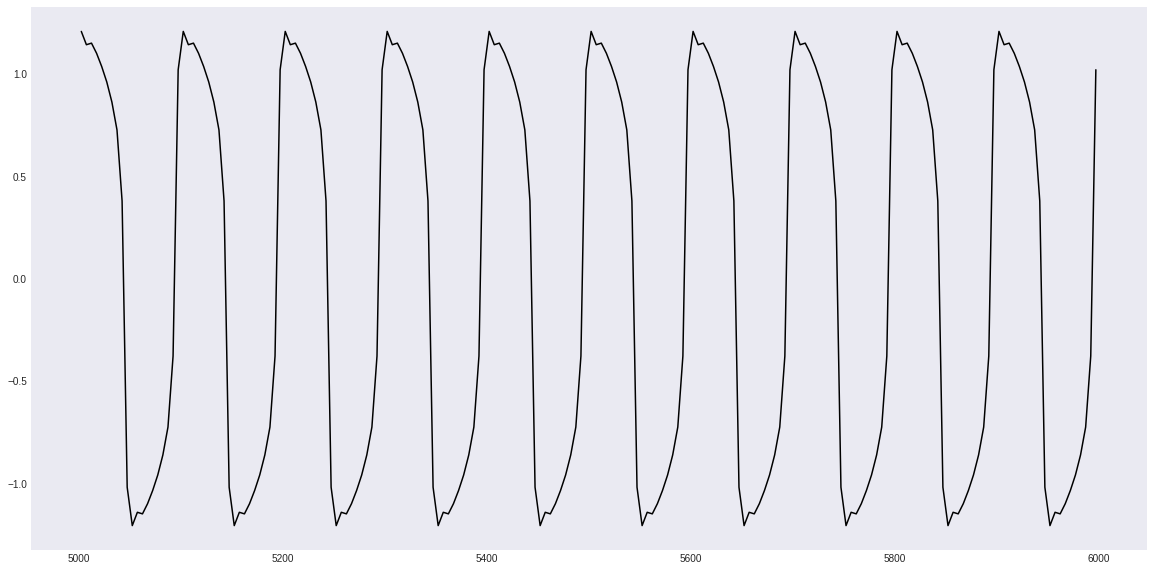

In [312]:
plt.figure(figsize=(20,10))
plt.plot(tavg_time[1000:1200], tavg_data[1000:1200,0,0,0], 'k');

In [313]:
from matplotlib.lines import Line2D
def phase_plane(
        model, 
        variables=None, 
        npoints=100, 
        state=None, 
        mode=0,
        title=None,
        square_aspect=False,
        faded=False,
        ax=None
):
    assert len(model.state_variables) > 1
    if ax is None:
        _, ax = plt.subplots(figsize=(10,8))

    if faded:
        color="lightgray"
        alpha=0.5
    else:
        color=None
        alpha=1

    if variables==None:
        svarx, svary = [0,1]
        variables = model.state_variables[:2]
    else:
        assert len(variables) == 2
        svarx = model.state_variables.index(variables[0])
        svary = model.state_variables.index(variables[1])

    if state is None:
        state = np.array([model.state_variable_range[key].mean() for key in model.state_variables])
        state = state[:,np.newaxis,np.newaxis]

    if title is None:
        title=model.__class__.__name__


    xlim = model.state_variable_range[variables[0]]
    ylim = model.state_variable_range[variables[1]]

    x = np.linspace( *xlim, npoints)
    y = np.linspace( *ylim, npoints)

    xx, yy = np.meshgrid(x,y)
    dx = np.zeros([len(y),len(x)])
    dy = np.zeros([len(y),len(x)])


    nocoupling = np.zeros(( model.nvar, 1, model.number_of_modes))
    for i in range(len(y)):
        for j in range(len(x)):
            state[svarx,0,:] = x[j]
            state[svary,0,:] = y[i]
            dstate = model.dfun(
                    state,
                    nocoupling
            )
            dx[i,j], dy[i,j] = dstate[[svarx,svary],0,mode]
    ax.streamplot(x,y,dx,dy,density=2.0,color=color)

    ax.set_xlabel(variables[0],fontsize=15.0)
    ax.set_ylabel(variables[1],fontsize=15.0)
    ax.contour(xx,yy,dx, [0], colors="r", alpha=alpha)
    ax.contour(xx,yy,dy, [0], colors="g", alpha=alpha)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    legend_elements = [
            Line2D([0], [0], color='r', alpha=alpha, label=f'$\dot {variables[0]}=0$'),
            Line2D([0], [0], color='g', alpha=alpha, label=f'$\dot {variables[1]}=0$'),
    ]
    ax.legend(handles=legend_elements,loc='upper right')
    ax.set_title(title)
    if square_aspect:
        ax.set_aspect(abs(xlim[0]-xlim[1])/abs(ylim[0]-ylim[1]))

    return ax

In [314]:
plt.xlim?

Signature: plt.xlim(*args, **kwargs)
Docstring:
Get or set the x limits of the current axes.

Call signatures::

    left, right = xlim()  # return the current xlim
    xlim((left, right))   # set the xlim to left, right
    xlim(left, right)     # set the xlim to left, right

If you do not specify args, you can pass *left* or *right* as kwargs,
i.e.::

    xlim(right=3)  # adjust the right leaving left unchanged
    xlim(left=1)  # adjust the left leaving right unchanged

Setting limits turns autoscaling off for the x-axis.

Returns
-------
left, right
    A tuple of the new x-axis limits.

Notes
-----
Calling this function with no arguments (e.g. ``xlim()``) is the pyplot
equivalent of calling `~.Axes.get_xlim` on the current axes.
Calling this function with arguments is the pyplot equivalent of calling
`~.Axes.set_xlim` on the current axes. All arguments are passed though.
File:      ~/anaconda3/envs/py3/lib/python3.9/site-packages/matplotlib/pyplot.py
Type:      function


(-2.0, 2.0)

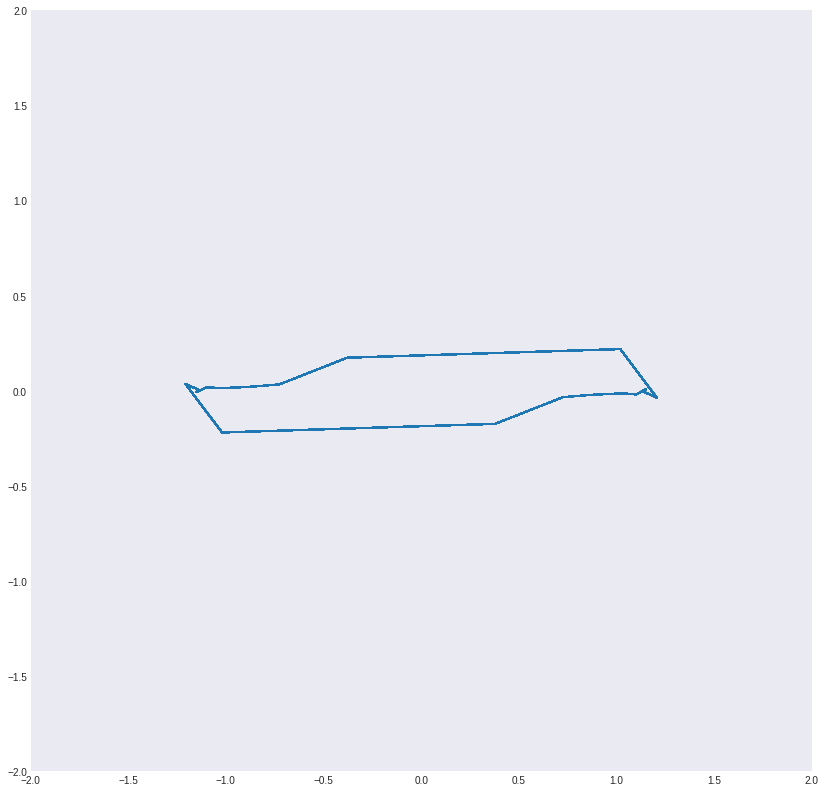

In [315]:
plt.figure(figsize = (14,14))
plt.plot(tavg_data[100:, 0,  0, 0], tavg_data[100:, 1, 0, 0],)
plt.xlim(-2.,2.); plt.ylim(-2.,2.)
#plt.savefig()